In [82]:
import seaborn as sns

from src.code.sentiment_analyzer import *
from src.code.preprocess_data import *
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')

C:\Users\szema\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# MODEL = f"mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# 
# _sentiment_analysis_mrm8488 = pipeline("sentiment-analysis",
#                                        model=model,
#                                        tokenizer=tokenizer)
# 
# _sentiment_analysis_ProsusAI = pipeline("sentiment-analysis",
#                                        model="ProsusAI/finbert")

## Read Data ##

In [ ]:
process_stock_data('../data/input/raw/source_1/AppleNewsStock.csv', '../data/input/processed/source_1/AppleNewsStock.csv')
process_stock_data('../data/input/raw/source_1/MicrosoftNewsStock.csv', '../data/input/processed/source_1/MicrosoftNewsStock.csv')

In [40]:
aapl_news = pd.read_csv('../data/input/processed/source_1/AppleNewsStock.csv')

msft_news = pd.read_csv('../data/input/processed/source_1/MicrosoftNewsStock.csv')


<Axes: xlabel='Date'>

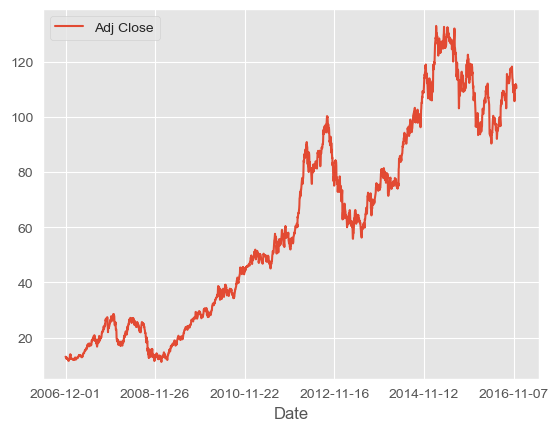

In [41]:
aapl_news.plot.line(y="Adj Close", x='Date')

<Axes: xlabel='Date'>

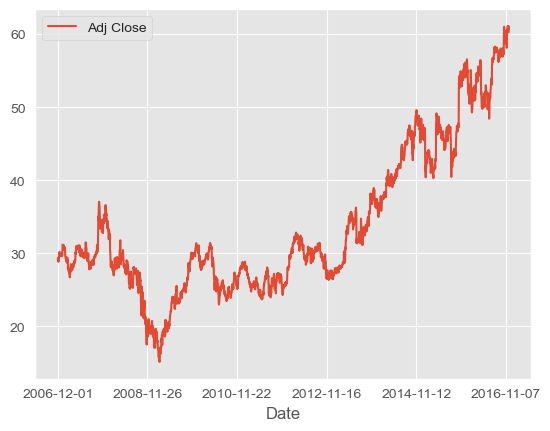

In [42]:
msft_news.plot.line(y="Adj Close", x='Date')

# Sentiment Analysis

### -Microsoft 

In [63]:
msft_news = calculate_volatility(msft_news)

<Axes: xlabel='Date'>

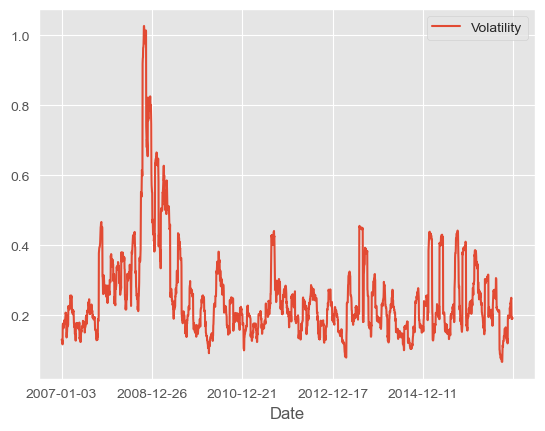

In [135]:
msft_news.plot.line(y="Volatility", x='Date')

In [43]:
msft_news = get_results(msft_news,'News', model="mrm8488")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [117]:
msft_news = check_prediction(msft_news,'Target','mrm8488_sentiment_score', "mrm8488", 0.64)

  0%|          | 0/2496 [00:00<?, ?it/s]

In [118]:
msft_prediction_accuracy = (sum((msft_news['mrm8488_predictions']))/len(msft_news.index))
msft_prediction_accuracy

0.7239583333333334

In [48]:
msft_news = get_results(msft_news,'News', model="ProsusAI")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [123]:
msft_news = check_prediction(msft_news,'Target','ProsusAI_sentiment_score', "ProsusAI", 0.64)

  0%|          | 0/2496 [00:00<?, ?it/s]

In [124]:
msft_prediction_accuracy_prosus = (sum((msft_news['ProsusAI_predictions']))/len(msft_news.index))
msft_prediction_accuracy_prosus

0.7972756410256411

### -Apple

In [70]:
aapl_news = calculate_volatility(aapl_news)

<Axes: xlabel='Date'>

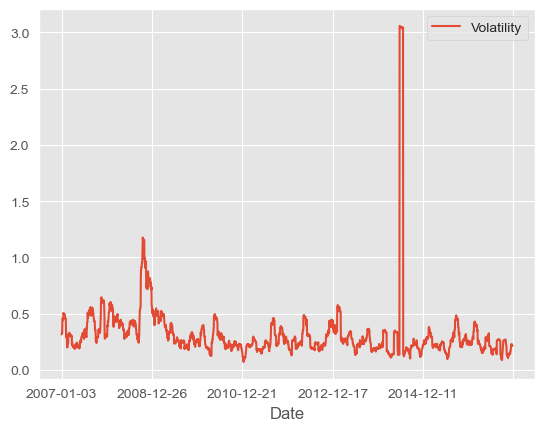

In [137]:
aapl_news.plot.line(y="Volatility", x='Date')

In [49]:
aapl_news = get_results(aapl_news,'News', model="mrm8488")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [59]:
aapl_news = get_results(aapl_news,'News', model="ProsusAI")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [125]:
aapl_news = check_prediction(aapl_news,'Target','mrm8488_sentiment_score', "mrm8488", 0.64)
aapl_news = check_prediction(aapl_news,'Target','ProsusAI_sentiment_score', "ProsusAI", 0.64)

  0%|          | 0/2496 [00:00<?, ?it/s]

  0%|          | 0/2496 [00:00<?, ?it/s]

In [126]:
aapl_prediction_accuracy = (sum((aapl_news['mrm8488_predictions']))/len(aapl_news.index))
aapl_prediction_accuracy

0.547676282051282

In [127]:
aapl_prediction_accuracy_prosus = (sum((aapl_news['ProsusAI_predictions']))/len(aapl_news.index))
aapl_prediction_accuracy_prosus

0.7504006410256411

# Plot Result Comparison #

In [128]:
fig = px.scatter(data_frame=msft_news,
                 x='mrm8488_sentiment_score', y='Target', template='plotly_white',
                 width=500,height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [130]:
fig = px.scatter(data_frame=msft_news,
                 x='ProsusAI_sentiment_score', y='Target', template='plotly_white',
                 width=500,height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [133]:
fig = px.scatter(data_frame=msft_news,
                 x='mrm8488_sentiment_score', y='ProsusAI_sentiment_score', template='plotly_white',
                 width=500,height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [131]:
fig = px.scatter(data_frame=aapl_news,
                 x='mrm8488_sentiment_score', y='Target', template='plotly_white',
                 width=500,height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [132]:
fig = px.scatter(data_frame=aapl_news,
                 x='ProsusAI_sentiment_score', y='Target', template='plotly_white',
                 width=500,height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [134]:
fig = px.scatter(data_frame=aapl_news,
                 x='mrm8488_sentiment_score', y='ProsusAI_sentiment_score', template='plotly_white',
                 width=500,height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()